<font color="red">注</font>: 使用 tensorboard 可视化需要安装 tensorflow (TensorBoard依赖于tensorflow库，可以任意安装tensorflow的gpu/cpu版本)

```shell
pip install tensorflow-cpu
```

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)
    
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 2.2.2
pandas 2.2.3
sklearn 1.6.1
torch 2.6.0+cpu
cpu


## 数据准备

https://www.kaggle.com/competitions/cifar-10/data

```shell
$ tree -L 1 cifar-10                                    
cifar-10
├── sampleSubmission.csv
├── test
├── train
└── trainLabels.csv
```

In [2]:
# # 解压训练集
# %pip install py7zr
# import py7zr
# a = py7zr.SevenZipFile(r'../input/cifar-10/train.7z','r')
# a.extractall(path=r'./')
# a.close()

In [3]:
# 我们不运行test数据集，太多图片
# !ls .

6_05_10_monkeys_model_2_resnet50_finetune_2_aliyun.ipynb  runs
6_06_cifar10_model_2-aliyun.ipynb			  sampleSubmission.csv
6_07_new-vgg-aliyun.ipynb				  submission.csv
6_08_new_inception_net2-aliyun.ipynb			  test
6_09_new_resnet-aliyun.ipynb				  test.7z
checkpoints						  train.7z
competitions						  trainLabels.csv
kaggle.json


In [4]:
# !mkdir test

mkdir: 无法创建目录 "test": 文件已存在


In [25]:
# 导入所需模块
from pathlib import Path
import pprint  # 用于格式化打印数据

# 设置数据目录
DATA_DIR = Path(".")  # 当前目录
DATA_DIR1 = Path("competitions/cifar-10/")  # 数据集所在目录

# 训练标签文件路径
train_lables_file = DATA_DIR / "trainLabels.csv"  # 训练集标签文件
test_csv_file = DATA_DIR / "sampleSubmission.csv"  # 测试集模板 CSV 文件

# 图像数据文件夹路径
train_folder = DATA_DIR1 / "train"  # 训练集图片所在文件夹
test_folder = DATA_DIR1 / "test"  # 测试集图片所在文件夹

# CIFAR-10 数据集中所有类别
class_names = [
    'airplane',   # 飞机
    'automobile', # 汽车
    'bird',       # 鸟
    'cat',        # 猫
    'deer',       # 鹿
    'dog',        # 狗
    'frog',       # 青蛙
    'horse',      # 马
    'ship',       # 船
    'truck',      # 卡车
]

def parse_csv_file(filepath, folder):
    """
    将 CSV 文件解析为 (图片路径, 标签) 格式的列表

    参数:
        filepath: Path 对象, CSV 文件路径
        folder: Path 对象, 图片所在的文件夹路径

    返回:
        list: 包含 (图片路径, 标签) 的元组列表
    """
    results = []
    # 打开 CSV 文件读取内容
    with open(filepath, 'r') as f:
        # 读取所有行，并跳过第一行（因为第一行是表头）
        lines = f.readlines()[1:] 
    for line in lines:  # 遍历每一行
        # 提取图像 ID 和标签（按逗号分隔）
        image_id, label_str = line.strip('\n').split(',')
        # 构建图像的完整路径
        image_full_path = folder / f"{image_id}.png"
        # 将路径和标签以元组形式保存到列表中
        results.append((image_full_path, label_str))
    return results

# 解析训练集和测试集 CSV 文件，得到图片路径与标签的对应信息
train_labels_info = parse_csv_file(train_lables_file, train_folder)
test_csv_info = parse_csv_file(test_csv_file, test_folder)

# 打印部分数据用于验证
pprint.pprint(train_labels_info[0:5])  # 打印前 5 条训练集信息
pprint.pprint(test_csv_info[0:5])     # 打印前 5 条测试集信息
print(len(train_labels_info), len(test_csv_info))  # 打印训练集和测试集的总数据量

[(PosixPath('competitions/cifar-10/train/1.png'), 'frog'),
 (PosixPath('competitions/cifar-10/train/2.png'), 'truck'),
 (PosixPath('competitions/cifar-10/train/3.png'), 'truck'),
 (PosixPath('competitions/cifar-10/train/4.png'), 'deer'),
 (PosixPath('competitions/cifar-10/train/5.png'), 'automobile')]
[(PosixPath('competitions/cifar-10/test/1.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/2.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/3.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/4.png'), 'cat'),
 (PosixPath('competitions/cifar-10/test/5.png'), 'cat')]
50000 300000


In [26]:
# train_labels_info 是训练集图片路径和标签的元组列表
# train_df 包含前 45000 条训练数据
train_df = pd.DataFrame(train_labels_info[0:45000])

# valid_df 包含剩余的训练数据（用作验证集）
valid_df = pd.DataFrame(train_labels_info[45000:])

# test_df 包含测试集的数据
test_df = pd.DataFrame(test_csv_info)

# 为 DataFrame 添加列名
train_df.columns = ['filepath', 'class']  # 训练集 DataFrame 包含 'filepath' 和 'class' 两列
valid_df.columns = ['filepath', 'class']  # 验证集 DataFrame 包含 'filepath' 和 'class' 两列
test_df.columns = ['filepath', 'class']   # 测试集 DataFrame 包含 'filepath' 和 'class' 两列

# 打印训练集的前 5 行数据
print(train_df.head())

# 打印验证集的前 5 行数据
print(valid_df.head())

# 打印测试集的前 5 行数据
print(test_df.head())

                            filepath       class
0  competitions/cifar-10/train/1.png        frog
1  competitions/cifar-10/train/2.png       truck
2  competitions/cifar-10/train/3.png       truck
3  competitions/cifar-10/train/4.png        deer
4  competitions/cifar-10/train/5.png  automobile
                                filepath       class
0  competitions/cifar-10/train/45001.png       horse
1  competitions/cifar-10/train/45002.png  automobile
2  competitions/cifar-10/train/45003.png        deer
3  competitions/cifar-10/train/45004.png  automobile
4  competitions/cifar-10/train/45005.png    airplane
                           filepath class
0  competitions/cifar-10/test/1.png   cat
1  competitions/cifar-10/test/2.png   cat
2  competitions/cifar-10/test/3.png   cat
3  competitions/cifar-10/test/4.png   cat
4  competitions/cifar-10/test/5.png   cat


In [32]:
from PIL import Image  # 用于加载和处理图像
from torch.utils.data import Dataset, DataLoader  # PyTorch 数据集和数据加载器
from torchvision import transforms  # PyTorch 提供的数据增强和转换工具

# 自定义 Cifar10 数据集类
class Cifar10Dataset(Dataset):
    # 数据模式到数据集 DataFrame 的映射
    df_map = {
        "train": train_df,  # 训练集
        "eval": valid_df,   # 验证集
        "test": test_df     # 测试集
    }
    # 标签到索引的映射，例如 'cat' -> 3
    label_to_idx = {label: idx for idx, label in enumerate(class_names)}
    # 索引到标签的映射，例如 3 -> 'cat'
    idx_to_label = {idx: label for idx, label in enumerate(class_names)}
    
    def __init__(self, mode, transform=None):
        """
        初始化数据集
        :param mode: 模式（train/eval/test）
        :param transform: 图像预处理和数据增强操作
        """
        # 获取对应模式的 DataFrame
        self.df = self.df_map.get(mode, None)
        if self.df is None:
            raise ValueError("mode should be one of train, eval, test, but got {}".format(mode))

        self.transform = transform  # 保存预处理操作
        
    def __getitem__(self, index):
        """
        获取数据集中的单个样本
        :param index: 数据索引
        :return: 预处理后的图像和对应标签
        """
        img_path, label = self.df.iloc[index]  # 获取图像路径和标签
        img = Image.open(img_path).convert('RGB')  # 打开图像并转换为 RGB 模式
        img = self.transform(img)  # 对图像应用预处理和数据增强
        label = self.label_to_idx[label]  # 将标签转换为索引
        return img, label
    
    def __len__(self):
        """
        返回数据集的大小
        """
        return self.df.shape[0]

# 图像大小
IMAGE_SIZE = 32
# 图像归一化的均值和标准差（根据 CIFAR-10 数据集计算）
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

# 训练集数据增强和预处理
transforms_train = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 调整图像大小
    transforms.RandomRotation(40),  # 随机旋转图像
    transforms.RandomHorizontalFlip(),  # 随机水平翻转
    transforms.ToTensor(),  # 转换为张量 (Channel, Height, Width)
    transforms.Normalize(mean, std)  # 归一化
])

# 验证集和测试集的预处理
transforms_eval = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # 调整图像大小
    transforms.ToTensor(),  # 转换为张量
    transforms.Normalize(mean, std)  # 归一化
])

# 创建训练集和验证集的 Dataset 对象
train_ds = Cifar10Dataset("train", transforms_train)  # 训练集
eval_ds = Cifar10Dataset("eval", transforms_eval)  # 验证集

In [33]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4)   
eval_dl = DataLoader(eval_ds, batch_size=batch_size, shuffle=False, num_workers=4)

In [31]:
# # 遍历train_ds得到每张图片，计算每个通道的均值和方差
# # 这里不需要每次都执行，只需要执行一次就可以了，所以注释掉
# def cal_mean_std(ds):
#     mean = 0.
#     std = 0.
#     for img, _ in ds:
#         mean += img.mean(dim=(1, 2))
#         std += img.std(dim=(1, 2))
#     mean /= len(ds)
#     std /= len(ds)
#     return mean, std

# # 经过 normalize 后 均值为0，方差为1
# print(cal_mean_std(train_ds))
# # (tensor([0.4368, 0.4267, 0.3947]), tensor([0.2465, 0.2419, 0.2359]))

(tensor([0.4368, 0.4267, 0.3947]), tensor([0.2465, 0.2419, 0.2359]))


## 定义模型

In [34]:
# 定义 VGG 网络模型，继承自 nn.Module
class VGG(nn.Module):
    def __init__(self, num_classes):
        """
        初始化 VGG 模型
        :param num_classes: 输出类别数量
        """
        super().__init__()
        # 使用 nn.Sequential 定义网络结构
        self.model = nn.Sequential(
            # （32, 32, 32, 32）-> (32, 32, 16, 16)
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding="same"),  # 32 * 3 * 3 * 3 = 864
            nn.ReLU(),  # 激活函数
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32 * 32 * 3 * 3 = 9216
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 最大池化，输出特征图大小减半

            # （32, 32, 16, 16）-> (32, 32, 8, 8)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32 * 32 * 3 * 3 = 9216
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32 * 32 * 3 * 3 = 9216
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 最大池化，输出特征图大小减半

            # （32, 32, 8, 8）-> (32, 32, 4, 4)
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32 * 32 * 3 * 3 = 9216
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding="same"),  # 32 * 32 * 3 * 3 = 9216
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),  # 最大池化，输出特征图大小减半
            
            nn.Flatten(),  # 将多维张量展平为 1 维 32*4*4 = 512
            nn.Linear(512, num_classes),  # 全连接层，将特征映射到类别数量 512 * 10 = 5120
        )
        self.init_weights()  # 初始化权重

    def init_weights(self):
        """
        初始化权重
        - 卷积层和全连接层使用 Xavier 均匀分布初始化权重
        - 偏置使用 0 初始化
        """
        for m in self.modules():
            if isinstance(m, (nn.Linear, nn.Conv2d)):  # 检测模块是否是 Linear 或 Conv2d
                nn.init.xavier_uniform_(m.weight)  # 使用 Xavier 均匀分布初始化
                nn.init.zeros_(m.bias)  # 偏置初始化为 0

    def forward(self, x):
        """
        前向传播
        :param x: 输入张量
        :return: 输出张量
        """
        return self.model(x)

# 打印每个参数的名称和数量
for key, value in VGG(len(class_names)).named_parameters():
    print(f"{key:^40}paramerters num: {np.prod(value.shape)}")

             model.0.weight             paramerters num: 864
              model.0.bias              paramerters num: 32
             model.2.weight             paramerters num: 9216
              model.2.bias              paramerters num: 32
             model.5.weight             paramerters num: 9216
              model.5.bias              paramerters num: 32
             model.7.weight             paramerters num: 9216
              model.7.bias              paramerters num: 32
            model.10.weight             paramerters num: 9216
             model.10.bias              paramerters num: 32
            model.12.weight             paramerters num: 9216
             model.12.bias              paramerters num: 32
            model.16.weight             paramerters num: 5120
             model.16.bias              paramerters num: 10


## 训练

pytorch的训练需要自行实现，包括
1. 定义损失函数
2. 定义优化器
3. 定义训练步
4. 训练

In [36]:
#模型总参数量
total_params = sum(p.numel() for p in VGG(len(class_names)).parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 52266


In [14]:
from sklearn.metrics import accuracy_score  # 导入计算准确率的工具

# 定义模型评估函数，使用 no_grad 装饰器来禁用梯度计算
@torch.no_grad()  
def evaluating(model, dataloader, loss_fct):
    """
    用于评估模型在验证集或测试集上的表现
    :param model: 训练好的模型
    :param dataloader: 验证集或测试集的数据加载器
    :param loss_fct: 损失函数，用于计算每一批次的损失
    :return: 返回损失的平均值和准确率
    """
    loss_list = []  # 用于存储每一批次的损失
    pred_list = []  # 用于存储所有的预测值
    label_list = []  # 用于存储所有的标签

    # 遍历整个数据集
    for datas, labels in dataloader:
        datas = datas.to(device)  # 将数据移到指定的设备（例如GPU）
        labels = labels.to(device)  # 将标签移到指定的设备
        
        # 前向传播计算预测结果
        logits = model(datas)  # 获取模型的输出 logits
        loss = loss_fct(logits, labels)  # 计算损失
        loss_list.append(loss.item())  # 保存当前批次的损失值
        
        # 获取预测的类别
        preds = logits.argmax(axis=-1)  # 获取预测结果，取 logits 中最大值的索引
        pred_list.extend(preds.cpu().numpy().tolist())  # 将预测结果从 GPU 移到 CPU，再转换为 numpy 数组，最后添加到预测列表
        label_list.extend(labels.cpu().numpy().tolist())  # 同理，将标签从 GPU 移到 CPU，再转换为 numpy 数组，添加到标签列表
        
    # 计算整个数据集的准确率
    acc = accuracy_score(label_list, pred_list)  # 计算标签与预测结果之间的准确率
    
    # 返回平均损失和准确率
    return np.mean(loss_list), acc

### TensorBoard 可视化


训练过程中可以使用如下命令启动tensorboard服务。

```shell
tensorboard \
    --logdir=runs \     # log 存放路径
    --host 0.0.0.0 \    # ip
    --port 8848         # 端口
```

In [15]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))
        
    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss", 
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )
        
    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )
        
    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,
            
        )
    
    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


### Save Best


In [16]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch. 
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = -1
        
        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)
        
    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return
        
        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



### Early Stop

In [17]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute 
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0
        
    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter 
            self.counter = 0
        else: 
            self.counter += 1
            
    @property
    def early_stop(self):
        return self.counter >= self.patience


In [37]:
# 训练
def training(
    model, 
    train_loader, 
    val_loader, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }
    
    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()
                preds = logits.argmax(axis=-1)
            
                acc = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())    
                loss = loss.cpu().item()
                # record
                
                record_dict["train"].append({
                    "loss": loss, "acc": acc, "step": global_step
                })
                
                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss, val_acc = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "acc": val_acc, "step": global_step
                    })
                    model.train()
                    
                    # 1. 使用 tensorboard 可视化
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step, 
                            loss=loss, val_loss=val_loss,
                            acc=acc, val_acc=val_acc,
                            lr=optimizer.param_groups[0]["lr"],
                            )
                
                    # 2. 保存模型权重 save model checkpoint
                    if save_ckpt_callback is not None:
                        save_ckpt_callback(global_step, model.state_dict(), metric=val_acc)

                    # 3. 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(val_acc)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict
                    
                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})
        
    return record_dict
        

epoch = 10

model = VGG(num_classes=10)

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.CrossEntropyLoss()
# 2. 定义优化器 采用 adam
# Optimizers specified in the torch.optim package
#可以修改adam里边的weight_decay参数，来控制L2正则化的程度,beta1和beta2是指数衰减率
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 1. tensorboard 可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
tensorboard_callback = TensorBoardCallback("runs/vgg")
tensorboard_callback.draw_model(model, [1, 3, IMAGE_SIZE, IMAGE_SIZE])
# 2. save best
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback("checkpoints/vgg", save_step=len(train_dl), save_best_only=True)
# 3. early stop
early_stop_callback = EarlyStopCallback(patience=5)

model = model.to(device)
record = training(
    model, 
    train_dl, 
    eval_dl, 
    epoch, 
    loss_fct, 
    optimizer, 
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_dl)
    )

100%|██████████| 7040/7040 [01:52<00:00, 62.58it/s, epoch=9]


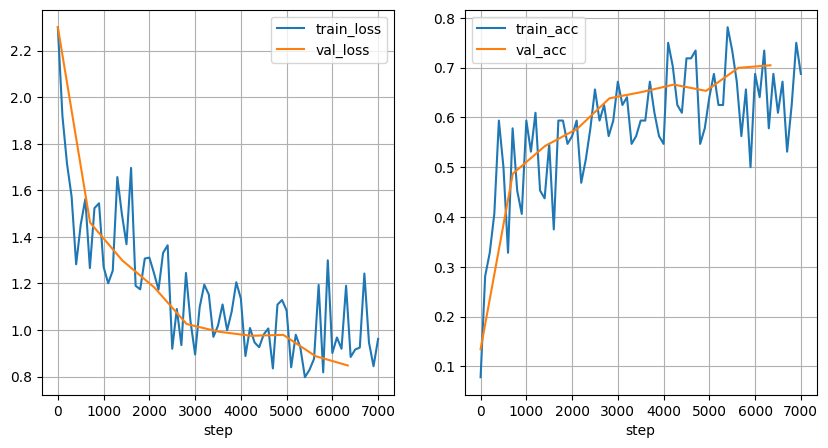

In [38]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    fig_num = len(train_df.columns)
    fig, axs = plt.subplots(1, fig_num, figsize=(5 * fig_num, 5))
    for idx, item in enumerate(train_df.columns):    
        axs[idx].plot(train_df.index, train_df[item], label=f"train_{item}")
        axs[idx].plot(val_df.index, val_df[item], label=f"val_{item}")
        axs[idx].grid()
        axs[idx].legend()
        # axs[idx].set_xticks(range(0, train_df.index[-1], 5000))
        # axs[idx].set_xticklabels(map(lambda x: f"{int(x/1000)}k", range(0, train_df.index[-1], 5000)))
        axs[idx].set_xlabel("step")
    
    plt.show()

plot_learning_curves(record, sample_step=100)  #横坐标是 steps

# 评估

In [39]:
# dataload for evaluating

# load checkpoints
model.load_state_dict(torch.load("checkpoints/vgg/best.ckpt", map_location="cpu", weights_only=True))

model.eval()
loss, acc = evaluating(model, eval_dl, loss_fct)
print(f"loss:     {loss:.4f}\naccuracy: {acc:.4f}")

loss:     0.8481
accuracy: 0.7048


# 推理

In [21]:
# # test_df
# test_ds = Cifar10Dataset("test", transform=transforms_eval)
# test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, drop_last=False)
#
# preds_collect = []
# model.eval()
# for data, fake_label in tqdm(test_dl):
#     data = data.to(device=device)
#     logits = model(data)
#     preds = [test_ds.idx_to_label[idx] for idx in logits.argmax(axis=-1).cpu().tolist()]
#     preds_collect.extend(preds)
#
# test_df["class"] = preds_collect
# test_df.head()

In [22]:
# # 导出 submission.csv
# test_df.to_csv("submission.csv", index=False)